In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)

In [22]:
# df_hs = pd.read_excel("data/上市公司沪市.xls",converters= {u'StockCode':str})
# df_ss = pd.read_excel("data/上市公司深市.xls",converters= {u'StockCode':str})
# df_zxb = pd.read_excel("data/上市公司中小板.xls",converters= {u'StockCode':str})
# df_cyb = pd.read_excel("data/上市公司创业板.xls",converters= {u'StockCode':str})

df_hsA = pd.read_excel("data/沪深A股.xls",converters= {u'StockCode':str})
df_szA = pd.read_excel("data/上证A股.xls",converters= {u'StockCode':str})
df_shenA = pd.read_excel("data/深证A股.xls",converters= {u'StockCode':str})

df_sz50 = pd.read_excel("data/上证50.xls",converters= {u'StockCode':str})
df_hs300 = pd.read_excel("data/沪深300.xls",converters= {u'StockCode':str})
df_zz500 = pd.read_excel("data/中证500.xls",converters= {u'StockCode':str})

In [64]:
# df = pd.concat([df_hs,df_ss])
df = pd.concat([df_szA,df_shenA])

In [65]:
# 处理百分比
def disposePercent(percent):
    index = str(percent).find('%')
    if index < 0:
        return 0
    else:
        return float(percent[:index])

# 处理数值
def disposeNumeric(numeric):
    try:
        return float(numeric)
    except Exception as e:
        return 0

def disposeUnit(price):
    price = price.replace('\n','').replace('\t','')
    unit = ['亿元','元','亿股']
    index = -1
    for u in unit:
        index = price.find(u)
        if index >= 0:
            break
    if index < 0:
        return 0
    else:
        return float(price[:index])
    
# 获取行业大类
def getTopTrade(trade):
    if trade == '-':
        return ''
    else:
        trades = trade.split('—')
        return trades[0].strip()
# 获取行业小类
def getSubTrade(trade):
    if trade == '-':
        return ''
    else:
        trades = trade.split('—')
        if len(trades) > 1:
            return trades[1].strip()
        else:
            return ''
    

def getNetProfitRate(np_des):
    np_des = np_des.strip()
    index_rate_s = np_des.find('增长')
    index_rate_e = np_des.find('%')
    
    if index_rate_s != -1:
        return float(np_des[index_rate_s+2:index_rate_e])
    else:
        return 0
    
def disposeNetProfitRate(netProfitRate):
    if netProfitRate == 0:
        return -1
    else:
        return netProfitRate


def disposeScaleShareType(sst):
    return sst.strip()

In [66]:
df['Price'] = df['Price'].apply(lambda x:disposeNumeric(x))

df['PB'] = df['PB'].apply(lambda x:disposeNumeric(x))

df['PE_S'] = df['PE_S'].apply(lambda x:disposeNumeric(x))

df['PE_D'] = df['PE_D'].apply(lambda x:disposeNumeric(x))

df['EarningsPerShare'] = df['EarningsPerShare'].apply(lambda x:disposeUnit(x))

df['NetProfit'] = df['NetProfitDes'].apply(lambda x:disposeUnit(x))

df['NetProfitRate'] = df['NetProfitDes'].apply(lambda x:getNetProfitRate(x))

df['GrossProfitRate'] = df['GrossProfitRate'].apply(lambda x:disposePercent(x))

df['NetAssetValuePerShare'] = df['NetAssetValuePerShare'].apply(lambda x:disposeUnit(x))

df['CapitalStock'] = df['CapitalStock'].apply(lambda x:disposeUnit(x))

df['ScaleShareType'] = df['ScaleShareType'].apply(lambda x:disposeScaleShareType(x))

df = df.drop(['NetProfitDes'],axis=1)

df['ROE'] = df['ROE'].apply(lambda x:disposePercent(x))

# 新建行业大类
df['TopTrade'] = df['Trade'].apply(lambda x:getTopTrade(x))

# 新建行业小类
df['SubTrade'] = df['Trade'].apply(lambda x:getSubTrade(x))

df = df.drop(['Trade'],axis=1)

# 新增市盈率增长率 = 市盈率（PE）/净利润增长率（NetProfitRate）
df['PEG'] = df['PE_S'] / df['NetProfitRate'].apply(lambda x:disposeNetProfitRate(x))

df['MoneyFlowPerShare'] = df['MoneyFlowPerShare'].apply(lambda x:disposeUnit(x))

In [67]:
df['PriceLimit'] = df['PriceLimit'].apply(lambda x:disposePercent(x))

df['QuantityRelativeR'] = df['QuantityRelativeR'].apply(lambda x:disposeNumeric(x))

df['TurnoverRate'] = df['TurnoverRate'].apply(lambda x:disposePercent(x))

# 行业分布

In [14]:
s_top = df.groupby(['TopTrade'],as_index=False).size()

In [15]:
s_top = s_top.sort_values(ascending=False)

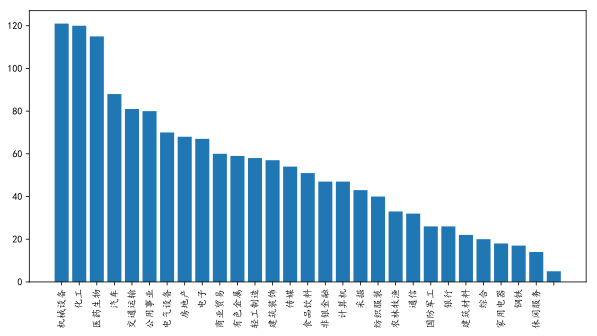

In [16]:
plt.figure(figsize=(10,5))
plt.bar(s_top.keys(),s_top.values)
plt.xticks(rotation=90)
plt.show()

In [7]:
# 根据指标获取优质股票
def getSuperiorStockByTargets(df,trade,targets,top):
    if len(targets) >= 2:
        code_list = []
        for target in targets:
            df_temp = df.copy()
            if target == 'PEG':
                df_temp = df_temp[df_temp['PEG'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            elif target == 'ROE/PB':
                df_temp = df_temp[df_temp['PB'] != 0]
                df_temp['ROE/PB'] = df_temp['ROE'] / df_temp['PB']
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=False).head(top)
            elif target == 'PB':
                df_temp = df_temp[df_temp['PB'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            elif target == 'PE_D':
                df_temp = df_temp[df_temp['PE_D'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            else:
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            
            code_list.append(list(df_temp['StockCode']))
        both = code_list[0]
        code_list.pop(0)
        while(len(code_list) > 0):
            next_list = code_list[0]
            both = [l for l in both if l in next_list]
            code_list.pop(0)
        return both
    
def getSuperiorStock(df):
    df_gpr = df.copy()
    #毛利率（高，30%~50%）
    df_gpr = df_gpr[df_gpr['GrossProfitRate'] > 30]
    
    #股本（低，小于10亿）
    df_cs = df.copy()
    df_cs = df_gpr[df_gpr['CapitalStock'] < 10]
    
    #净资产收益率（ROE）（高，大于5%）
    df_roe = df.copy()
    df_roe = df_roe[df_roe['ROE'] > 5]
    
    #小盘股
    df_sst = df.copy()
    df_sst = df_sst[df_sst['ScaleShareType'] == '小盘股']
    
    df_list = [df_gpr,df_cs,df_roe,df_sst]
    code_list = []
    for d in df_list:
        code_list.append(list(d['StockCode']))    

    both = code_list[0]
    code_list.pop(0)
    
    while(len(code_list) > 0):
        next_list = code_list[0]
        both = [l for l in both if l in next_list]
        code_list.pop(0)
    return both

# 选股策略，只做初步筛选

In [68]:
df_target = df[
    #去掉创业板
    df['StockCode'].apply(lambda x:x.find('3') != 0) &
    #去掉科创
    df['StockCode'].apply(lambda x:x.find('68') != 0) &
    #去掉ST、*ST
    df['StockName'].apply(lambda x:x.find('*ST') != 0) &
    df['StockName'].apply(lambda x:x.find('ST') != 0) &
    #去掉破净股
#     df['FinanceAnalize'].apply(lambda x:str(x).find('破净股') < 0) &
    #每股收益大于0
    (df['EarningsPerShare'] > 0) & 
    #净利润大于30%
#     (df['GrossProfitRate'] > 30) & 
    #净资产收益率
    (df['ROE'] >= 15) &
    #市净率
    (df['PB'] < 2 ) &
    #市盈率
    (df['PE_D'] < 80) & 
    #股价小于10
    ((df['Price'] < 100) & (df['Price'] != 0) ) & 
    #去掉夕阳行业
    (df['SubTrade'] != '银行') & 
    (df['SubTrade'] != '有色冶炼加工') & 
    (df['SubTrade'] != '房地产开发') & 
    (df['SubTrade'] != '煤炭开采加工') & 
    (df['SubTrade'] != '钢铁') & 
    (df['SubTrade'] != '汽车整车') & 
    (df['SubTrade'] != '汽车零部件') & 
    (df['SubTrade'] != '纺织制造') & 
    (df['SubTrade'] != '电力') &
    (df['TopTrade'] != '房地产') &
    (df['PriceLimit'] < 0)
    #换手率
#     (df['QuantityRelativeR'] > 1) 
    ].sort_values(by=['ROE'],ascending=False)

In [62]:
df_target = df[df['StockCode'].apply(lambda x:x in ['601318','603868','600887','603589','603369','600690','603816','600612',
                                                    '000895','000333','000651','002415','000963','002372','000049','002508','000921','002262','002242']) &
               #市盈率下降
               (df['PE_D'] < df['PE_S']) &
               #每股现金流不为负
               (df['MoneyFlowPerShare'] > 0)
              ].sort_values(by=['EarningsPerShare'],ascending=False)

In [69]:
df_target

,StockCode,StockName,Price,PriceLimit,QuantityRelativeR,TurnoverRate,PB,PE_S,PE_D,EarningsPerShare,ROE,GrossProfitRate,NetAssetValuePerShare,CapitalStock,ScaleShareType,FinanceAnalize,MoneyFlowPerShare,NetProfit,NetProfitRate,TopTrade,SubTrade,PEG
1397,600052,浙江广厦,4.25,-2.75,0.66,1.93,1.06,32.34,2.376,1.38,39.79,62.68,4.11,8.72,小盘股,NaN,1.01,12.03,1011.71,传媒,文化传媒,0.031966
1383,000933,神火股份,4.58,-1.51,1.42,1.47,1.04,37.00,2.627,1.33,32.61,16.60,4.49,19.00,中盘股,NaN,0.41,25.23,730.83,有色金属,工业金属,0.050627
1224,601918,新集能源,3.41,-1.73,1.55,1.86,1.23,34.40,3.482,0.75,30.62,41.82,2.83,25.91,中盘股,NaN,1.22,19.36,113.28,采掘,煤炭开采Ⅱ,0.303672
835,600368,五洲交通,4.28,-0.70,1.06,0.52,1.13,11.44,4.254,0.76,21.78,45.26,3.82,11.26,中盘股,"绩优股,",0.47,8.55,191.37,交通运输,高速公路Ⅱ,0.059779
1323,600587,新华医疗,13.26,-2.21,0.64,0.92,1.29,236.36,5.034,1.97,21.65,21.76,10.21,4.06,中盘股,NaN,1.09,8.02,422.08,医药生物,医疗器械Ⅱ,0.559989
673,002011,盾安环境,4.64,-0.22,1.20,0.67,1.55,0.00,6.283,0.55,20.51,17.00,2.99,9.17,中盘股,NaN,0.46,5.08,1127.83,家用电器,白色家电,0.000000
719,000885,城发环境,10.10,-0.30,0.97,0.39,1.72,8.63,6.777,1.12,20.35,61.26,5.90,4.96,中盘股,"绩优股,",1.91,5.56,27.46,交通运输,高速公路Ⅱ,0.314275
706,600668,尖峰集团,13.63,-0.44,1.30,1.87,1.29,8.00,5.749,1.79,17.95,40.99,10.58,3.44,中盘股,"绩优股,",1.04,6.15,25.89,建筑材料,水泥制造,0.309000
677,600352,浙江龙盛,13.18,-0.38,1.51,1.02,1.82,10.47,8.315,1.22,17.68,41.58,7.26,32.53,大盘股,"二线蓝筹,绩优股,",1.30,38.82,22.13,化工,化学制品,0.473113
1426,600136,当代明诚,9.45,-3.08,1.30,1.46,1.13,25.87,5.294,1.34,17.62,36.79,8.33,4.87,中盘股,"白马股,绩优股,",2.00,6.52,401.26,传媒,文化传媒,0.064472
